# 计算机视觉——SIFT特征点提取、描述与匹配

参考：
1. https://www.geeksforgeeks.org/sift-interest-point-detector-using-python-opencv/
2. https://blog.csdn.net/zddblog/article/details/7521424
3. https://www.analyticsvidhya.com/blog/2019/10/detailed-guide-powerful-sift-technique-image-matching-python/
4. https://medium.com/data-breach/introduction-to-sift-scale-invariant-feature-transform-65d7f3a72d40
5. https://www.cnblogs.com/Alliswell-WP/p/SIFT.html#:~:text=%E5%B0%BA%E5%BA%A6%E4%B8%8D%E5%8F%98%E7%89%B9%E5%BE%81%E8%BD%AC%E6%8D%A2,%E5%8F%91%E8%A1%A8%EF%BC%8C2004%E5%B9%B4%E5%AE%8C%E5%96%84%E6%80%BB%E7%BB%93%E3%80%82
6. https://medium.com/@russmislam/implementing-sift-in-python-a-complete-guide-part-1-306a99b50aa5
7. https://medium.com/@russmislam/implementing-sift-in-python-a-complete-guide-part-2-c4350274be2b
8. https://blog.csdn.net/hujingshuang/article/details/44995829

In [1]:
import cv2
import numpy as np
import math

import  matplotlib.pyplot as plt

In [2]:
def imshow(img):
    """
    jupyter 内部可视化图像
    """
    plt.figure(dpi=150)
    plt.axis('off')
    # 3通道图像应从BGR转RGB再显示
    if len(img.shape)==3:
        img = img[:,:,::-1] 	# transform image to rgb
    # 灰度图应转为RGB
    else:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    plt.imshow(img)
    plt.show()

In [3]:
def convert(img):
    # 3通道图像应从BGR转RGB再显示
    if len(img.shape)==3:
        img = img[:,:,::-1] 	# transform image to rgb
    # 灰度图应转为RGB
    else:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    return img

## 1. 特征点提取——SIFT特征点检测

In [4]:
# 读取图像
image = cv2.imread("images/Lena.png")
# 转灰度图
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # 转化为灰度图

### 1.1 差分高斯金字塔

下面开始是一些分析的可视化，不是正规函数

高斯平滑具有一个平方特性，即进行一次$\sigma_1$的平滑，再进行一次$\sigma_2$的平滑，相当于进行一次$\sqrt{\sigma_1^2 + \sigma_2^2}$的平滑。

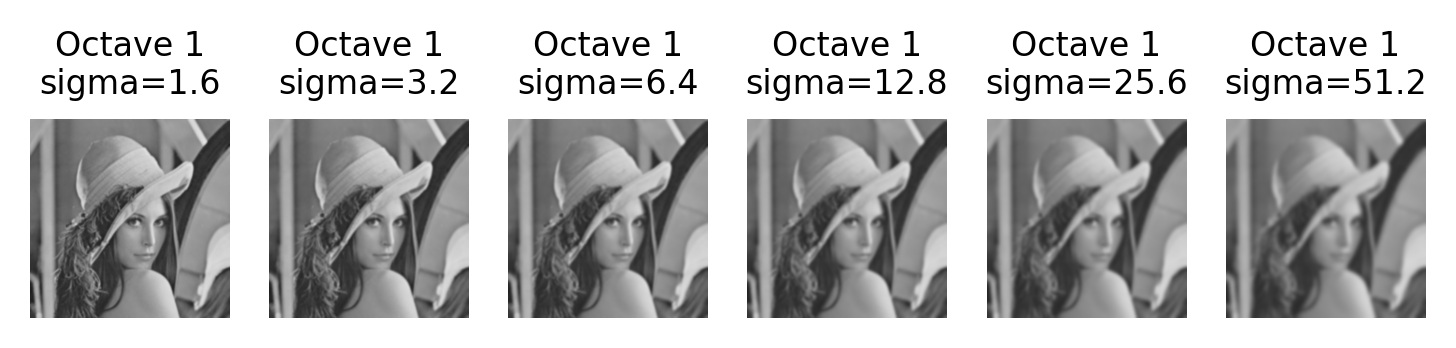

In [5]:
# 高斯模糊函数
blur_image = cv2.GaussianBlur(image, ksize=(0,0), sigmaX=1.6, sigmaY=1.6)

# 计算多次平滑
s = 3
k = 2**(1./s)
sigma_list = [1.6]
for i in range(1,6):
    sigma = math.sqrt((sigma_list[0] * k**i)**2 - (sigma_list[0] * k**(i-1))**2)
    sigma_list.append(sigma)

octave = []
octave.append(blur_image)

for i in range(1,6):
    blur_image = cv2.GaussianBlur(blur_image, ksize=(0,0), sigmaX=sigma_list[i], sigmaY=sigma_list[i])
    octave.append(blur_image)

plt.figure(dpi=300)

for i in range(6):
    plt.subplot(1,6,i+1)
    plt.imshow(convert(octave[i]))
    plt.title("Octave {}\nsigma={}".format(1, 1.6*(2**i)), fontsize=8)
    plt.axis('off')
plt.show()

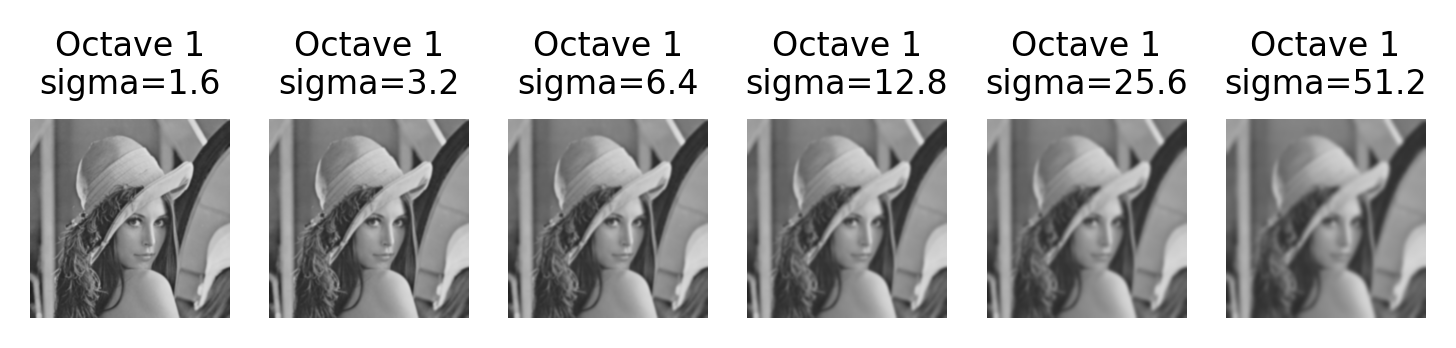

In [6]:
# 高斯模糊函数
blur_image = cv2.GaussianBlur(image, ksize=(0,0), sigmaX=1.6, sigmaY=1.6)

# 计算多次平滑
s = 3
k = 2**(1/s)

octave2 = []
octave2.append(blur_image)

for i in range(1,6):
    blur_image = cv2.GaussianBlur(image, ksize=(0,0), sigmaX=(k**i)*1.6, sigmaY=(k**i)*1.6)
    octave2.append(blur_image)

plt.figure(dpi=300)

for i in range(6):
    plt.subplot(1,6,i+1)
    plt.imshow(convert(octave2[i]))
    plt.title("Octave {}\nsigma={}".format(1, 1.6*(2**i)), fontsize=8)
    plt.axis('off')
plt.show()

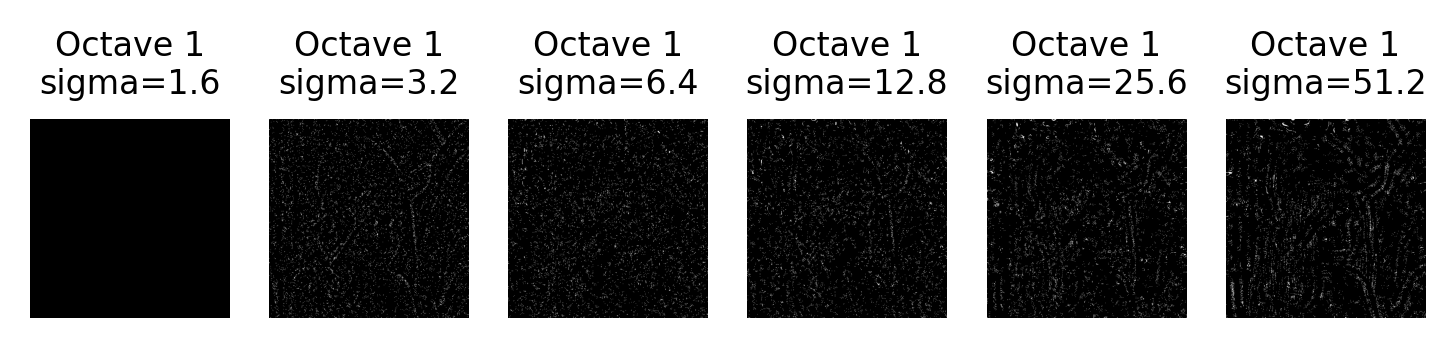

In [7]:
plt.figure(dpi=300)
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.imshow(convert(octave2[i]-octave[i]))
    plt.title("Octave {}\nsigma={}".format(1, 1.6*(2**i)), fontsize=8)
    plt.axis('off')
plt.show()
## 几乎没有差异

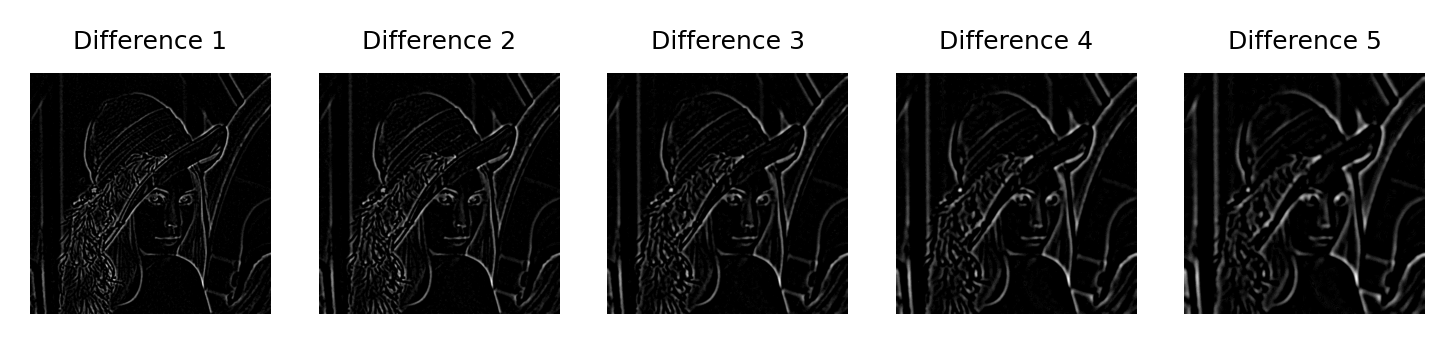

In [8]:
## 第一层高斯差分
# 高斯模糊函数
difference = []

for i in range(5):
    # difference.append(octave[i+1].astype(int)-octave[i].astype(int))
    difference.append(cv2.subtract(octave[i+1],octave[i]))

plt.figure(dpi=300)
for i in range(1,6):
    plt.subplot(1,5,i)
    plt.imshow(difference[i-1], cmap=plt.get_cmap('gray'))
    plt.title("Difference {}".format(i), fontsize=6)
    plt.axis('off')
plt.show()

下面定义DoG尺度空间函数

其中高斯模糊系数$\sigma(o,r) = \sigma_0{o,r} 2^{o+\frac{r}{s}}$，其中
$o \in [0, ..., O-1], r \in [0, ... , s+2]$


In [9]:
# 细节理论参考：https://www.cnblogs.com/Alliswell-WP/p/SIFT.html#:~:text=%E5%B0%BA%E5%BA%A6%E4%B8%8D%E5%8F%98%E7%89%B9%E5%BE%81%E8%BD%AC%E6%8D%A2,%E5%8F%91%E8%A1%A8%EF%BC%8C2004%E5%B9%B4%E5%AE%8C%E5%96%84%E6%80%BB%E7%BB%93%E3%80%82

def compute_linear_sigma(init_sigma, scale_num, k):
    """
    计算相邻模糊图像之间的参数
    之前的层参数是基于原始图像
    """
    sigma_list = [init_sigma]
    for i in range(1, scale_num + 3):
        sigma = math.sqrt((sigma_list[0] * k**i)**2 - (sigma_list[0] * k**(i-1))**2)
        sigma_list.append(sigma)
    return sigma_list

def GaussianLayer(blur_image, init_sigma, scale_num):
    """
    高斯金字塔层
    Input:
        image: 第一层已经经过模糊处理的图像
        init_sigma: 第一层模糊图像的尺度参数，一般为current_octave_num * sigma_0
    """
    # 该层的模糊图像
    octave = []
    octave.append(blur_image)

    k = 2 ** ( 1 / scale_num )
    sigma_list = compute_linear_sigma(init_sigma, scale_num, k)

    # scale_num+3，没有问题，scale_num是用于检测极值点的图像，差分图像减了2，差分图与金字塔层的图数目差1，故总共差3
    for i in range(1,scale_num+3):  # sigma_list[0] 为初始化的，不需要用。
        blur_image = cv2.GaussianBlur(blur_image, ksize=(0,0), sigmaX=sigma_list[i], sigmaY=sigma_list[i])
        octave.append(blur_image)
    
    return octave

def DifferenceLayer(octave):
    """
    差分层，计算一层金字塔层的差分层
    """
    difference = []

    for i in range(len(octave)-1):
        # 这里需要转换格式，不然负值，CV2会归0的
        # difference.append(octave[i+1].astype(int)-octave[i].astype(int))
        difference.append(cv2.subtract(octave[i+1],octave[i]))

    return difference


def DoG(image, sigma=1.6, scale_num=3):
    """
    Input:
        image: 输入图像为灰度图或者BGR图像均可，格式建议为CV2的格式
        sigma: 尺度参数，建议1.6，实际相机参数有0.5的修正，针对相机图像可以为1.52
        scale_num: 高斯金字塔每层的尺度数

    Output:
        DoG_space: 列表，长度为 (octave_num - 1)
    """
    if len(image) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # 转化为灰度图

    # 高斯模糊函数
    blur_image = cv2.GaussianBlur(image, ksize=(0,0), sigmaX=sigma, sigmaY=sigma)

    # 计算金字塔层的参数，论文有给
    Octave_num = int(round(math.log2(min(image.shape)) - 2))
   
    # Differnece of Gaussian空间
    DoG_space = []
    # Gaussian Blur Image
    Gaussian_octave = []

    for Octave_index in range(1, Octave_num+1):
        # 每一层初始的sigma数值与层数正比
        init_sigma = Octave_index * sigma
        # 金字塔层的高斯模糊图像，List[scale_num+3]
        octave = GaussianLayer(blur_image, init_sigma, scale_num)
        Gaussian_octave.append(octave)
        # 高斯差分层的差分图像，List[scale_num]
        difference = DifferenceLayer(octave)
        # 选择金字塔层倒数第三张图像并下采样作为下一层的初始图像
        # blur_image = cv2.resize(octave[-3], (0, 0), fx=0.5, fy=0.5, interpolation=cv2.INTER_NEAREST)
        blur_image = cv2.resize(octave[-3], (int(octave[-3].shape[1] / 2), int(octave[-3].shape[0] / 2)), interpolation=cv2.INTER_NEAREST)

        DoG_space.append(difference)

    return DoG_space, Gaussian_octave

计算DoG尺度变换空间

In [10]:
DoG_space, Gaussian_octave = DoG(image)

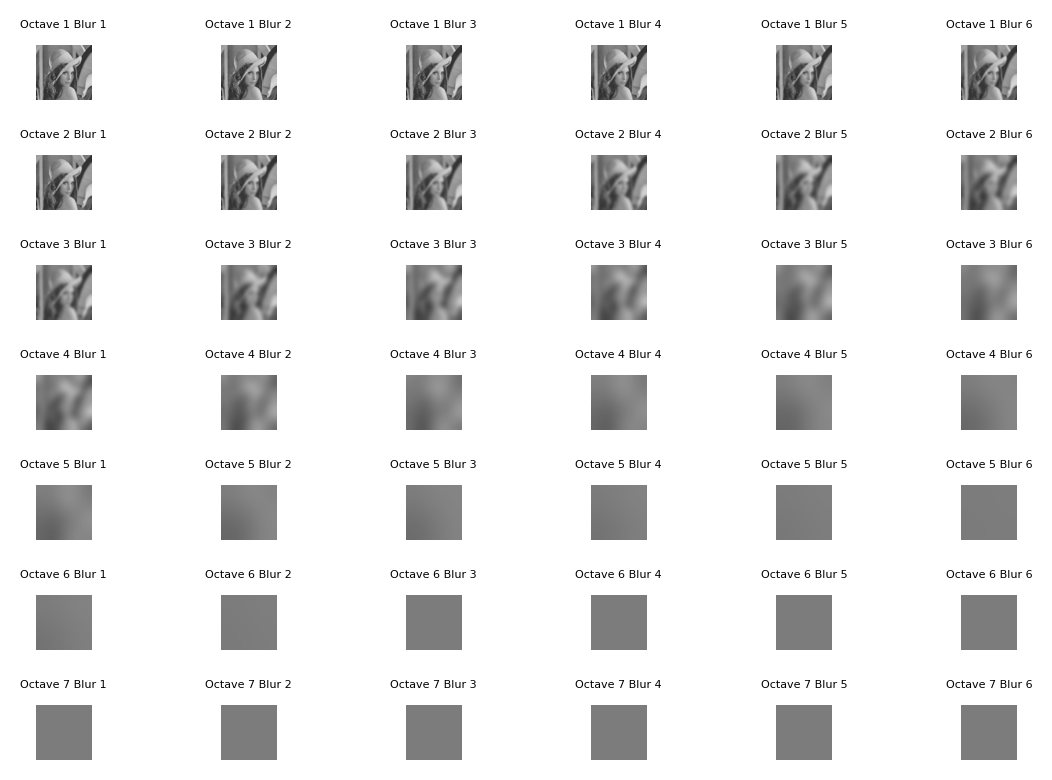

In [13]:
## 可视化模糊图
i = 1
j = 1
plt.figure(dpi=200)
for Blur in Gaussian_octave:
    for blur_image in Blur:
        plt.subplot(len(Gaussian_octave),len(Blur),i)
        plt.imshow(cv2.cvtColor(blur_image, cv2.COLOR_GRAY2RGB))
        plt.title("Octave {} Blur {}".format(j, (i-1)%len(Blur)+1), fontsize=4)
        plt.axis('off')
        
        # plt.yticks(fontproperties = 'Times New Roman', size = 4)
        # plt.xticks(fontproperties = 'Times New Roman', size = 4)
        i += 1
    j += 1
plt.tight_layout()
plt.show()

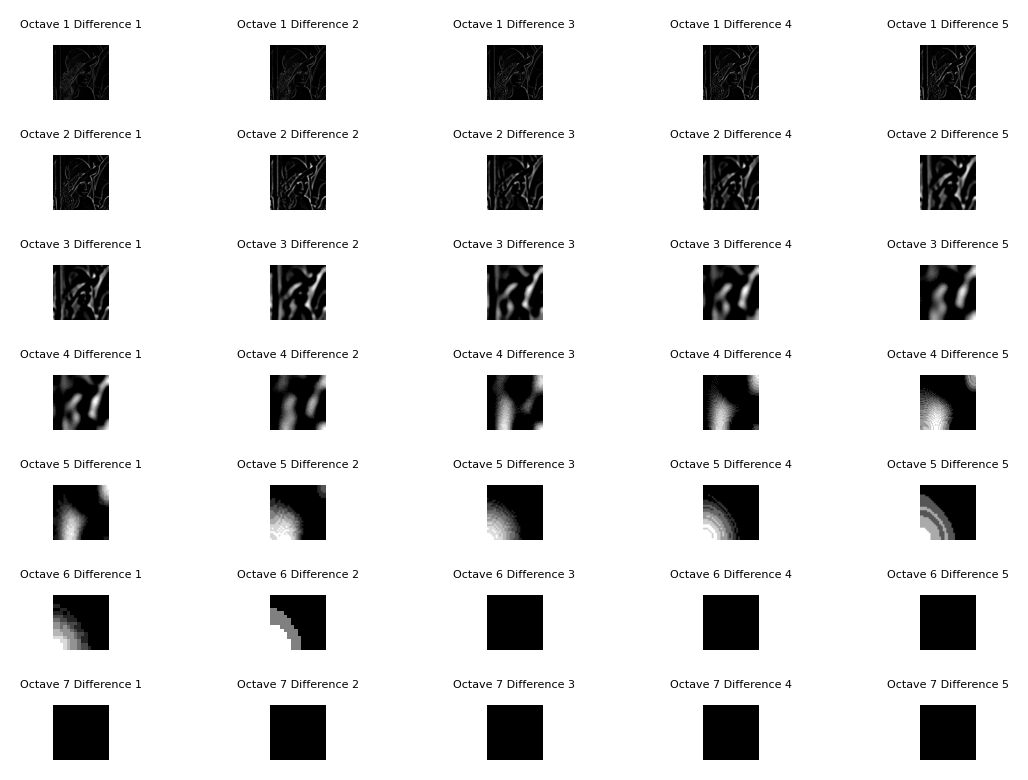

In [14]:
## 可视化
i = 1
j = 1
plt.figure(dpi=200)
for difference in DoG_space:
    for difference_image in difference:
        plt.subplot(len(DoG_space),len(difference),i)
        plt.imshow(difference_image, cmap=plt.get_cmap('gray'))
        plt.title("Octave {} Difference {}".format(j, (i-1)%len(difference)+1), fontsize=4)
        plt.axis('off')
        # plt.yticks(fontproperties = 'Times New Roman', size = 4)
        # plt.xticks(fontproperties = 'Times New Roman', size = 4)
        i += 1
    j += 1
plt.tight_layout()
plt.show()

## 1.2 DoG尺度空间极值点检测

In [60]:
def ExtremePointDetection(difference_images, scale_num=3, contrast_threshold=0.04, image_border_width=5):
    """
    计算每一层的极值点
    每层实际检测的尺寸为[M-5,N-5]
    极值点所在面为除了两端面外
    """
    difference_images = np.array(difference_images) # s+2,w,h

    # 对比度阈值
    threshold = np.floor(0.5 * contrast_threshold / scale_num * 255)  # from OpenCV implementation

    extrame_points = []
    # 循环扫描：
    for layer in range(1,difference_images.shape[0]-1):
        for row in range(image_border_width, difference_images.shape[1]-5):
            for col in range(image_border_width, difference_images.shape[2]-5):
                sub_space = difference_images[layer-1:layer+2, row-1:row+2, col-1:col+2]
                if difference_images[layer, row, col] > threshold:  # 去除低对比度的
                    # 是否为极值点
                    if ExtremumPixel(sub_space):   # 最大值
                        location = AccurateLocation(difference_images, layer, row, col, threshold, image_border_width, offset=0.5, epoch=5, r=10)
                        if location is not None and [location[0], location[1], location[2]] not in extrame_points:
                            extrame_points.append([location[0], location[1], location[2]])
                        
    return extrame_points

def ExtremumPixel(sub_space):
    """
    判断是否是极值点
    """
    if sub_space[1, 1, 1] == sub_space.max():   # 最大值
        return True
    elif sub_space[1, 1, 1] == sub_space.min(): # 最小值
        return True
    else:
        return False

def AccurateLocation(difference_images, layer, row, col, threshold, image_border_width=5, offset=0.5, epoch=5, r=10):
    """
    精确定位关键点位置，此时需要拟合函数
    """
    # 循环执行：计算精细偏移量；偏移量大于一定数值改变位置；改变关键点初始位置
    for i in range(epoch):
        sub_space = difference_images[layer-1:layer+2, row-1:row+2, col-1:col+2]
        gradient = FirstOrderDerivative(sub_space/255.)
        hessian  = Hessian(sub_space/255.)
        # 拟合，即负的海森矩阵的逆×一阶导
        extremum_update = -np.linalg.lstsq(hessian, gradient, rcond=None)[0]
        if (abs(extremum_update)<offset).sum() == 3:   # 如果3方面偏移均小于0.5，则不再更新。
            break
        # 改变关键点初始位置
        col += int(round(extremum_update[0]))   # 没写错，这是一阶导顺序问题
        row += int(round(extremum_update[1]))
        layer += int(round(extremum_update[2]))
        if col < image_border_width or col > difference_images.shape[2] - image_border_width or row < image_border_width or row > difference_images.shape[1] - image_border_width or layer < 1 or layer > difference_images.shape[0]-2:
            # 超界了，不要
            return None
    if i == epoch-1:
        # 没有精准定位
        return None
    # 接下来去除边缘上的点，消除边缘响应
    if difference_images[layer, row, col] > threshold:
        Tr, Det = Hessian_2x2(difference_images[layer, row-1:row+2, col-1:col+2]/255.)
        if Det > 0 and Tr**2/Det < (r+1)**2/r:  # 特征值之间比值
            return (1, row, col)

    # functionValueAtUpdatedExtremum = sub_space[1, 1, 1] + 0.5 * np.dot(gradient, extremum_update)
    # if abs(functionValueAtUpdatedExtremum) * 3 >= 0.05:
    #     xy_hessian = hessian[:2, :2]
    #     xy_hessian_trace = np.trace(xy_hessian)
    #     xy_hessian_det = np.linalg.det(xy_hessian)
    #     if xy_hessian_det > 0 and r * (xy_hessian_trace ** 2) < ((r + 1) ** 2) * xy_hessian_det:
    #         row = int((row + extremum_update[1]) * (2 ** 1))
    #         col = int((col + extremum_update[0]) * (2 ** 1))
    #     return (1,row,col)
    # 如果不满足，说明对比度不足或者关键点不稳定，无
    return None

def FirstOrderDerivative(sub_space):
    """
    计算一阶导数
    """
    return np.array([
        0.5 * (sub_space[1,1,2] - sub_space[1,1,0]),
        0.5 * (sub_space[1,2,1] - sub_space[1,0,1]),
        0.5 * (sub_space[2,1,1] - sub_space[0,1,1])
    ])

def Hessian(sub_space):
    """
    计算二阶导数，即海森矩阵
    """
    center_pixel_value = sub_space[1, 1, 1]
    dxx = sub_space[1, 1, 2] - 2 * center_pixel_value + sub_space[1, 1, 0]
    dyy = sub_space[1, 2, 1] - 2 * center_pixel_value + sub_space[1, 0, 1]
    dss = sub_space[2, 1, 1] - 2 * center_pixel_value + sub_space[0, 1, 1]
    dxy = 0.25 * (sub_space[1, 2, 2] - sub_space[1, 2, 0] - sub_space[1, 0, 2] + sub_space[1, 0, 0])
    dxs = 0.25 * (sub_space[2, 1, 2] - sub_space[2, 1, 0] - sub_space[0, 1, 2] + sub_space[0, 1, 0])
    dys = 0.25 * (sub_space[2, 2, 1] - sub_space[2, 0, 1] - sub_space[0, 2, 1] + sub_space[0, 0, 1])
    return np.array([[dxx, dxy, dxs], 
                  [dxy, dyy, dys],
                  [dxs, dys, dss]])

def Hessian_2x2(sub_space):
    """
    计算图像的二阶导
    """
    center_pixel_value = sub_space[1, 1]
    dxx = sub_space[1, 2] - 2 * center_pixel_value + sub_space[1, 0]
    dyy = sub_space[2, 1] - 2 * center_pixel_value + sub_space[0, 1]
    dxy = 0.25 * (sub_space[2, 2] - sub_space[2, 0] - sub_space[0, 2] + sub_space[0, 0])
    Tr = dxx + dyy
    Det = dxx * dyy - dxy * dxy
    return Tr, Det

In [61]:
extrame_points = ExtremePointDetection(difference_images = DoG_space[0])

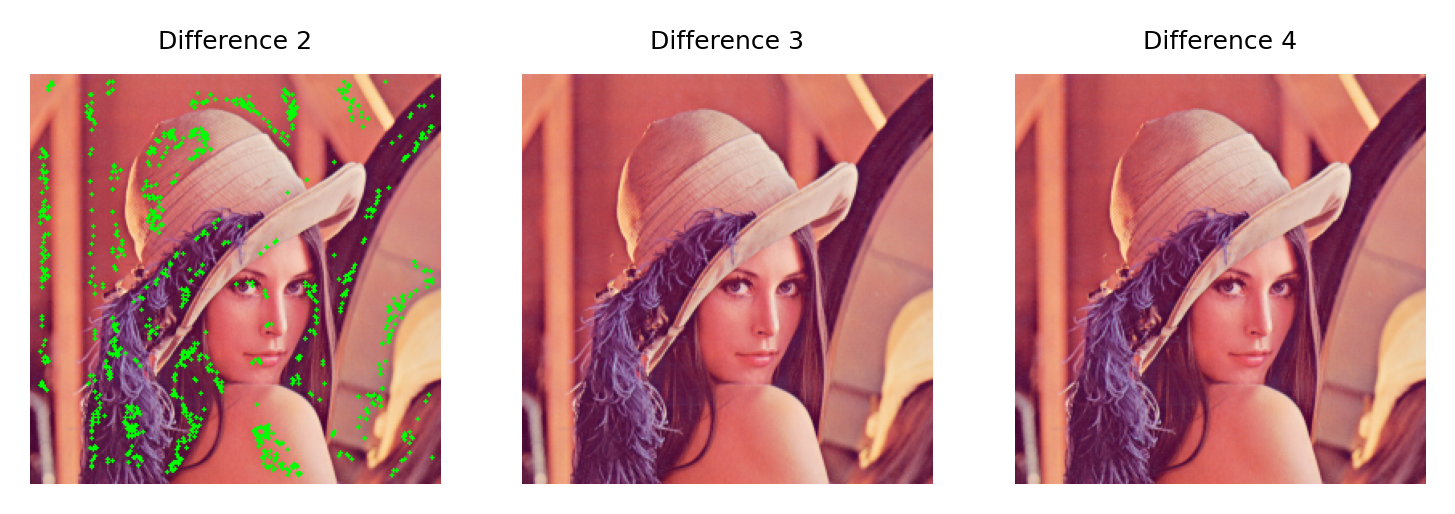

In [63]:
lr = 1  # 第lr层

extrame_points = ExtremePointDetection(difference_images = DoG_space[lr])
DoG_space_copy = DoG_space[lr].copy()

# 读取图像
image_ = cv2.imread("images/Lena.png")
image_ = cv2.resize(image_, dsize=(DoG_space_copy[0].shape[1], DoG_space_copy[0].shape[0]))

image_space = []
for img in DoG_space_copy:
    # image_space.append(cv2.cvtColor(image_, cv2.COLOR_GRAY2RGB))
    image_space.append(image_.copy())

# 可视化Octave2的极值点：
for layer, row, col in extrame_points:
    cv2.circle(image_space[layer], center=(col, row), radius=1, color=[0,255,0], thickness=-1)

plt.figure(dpi=300)
for i in range(1,4):
    plt.subplot(1,3,i)
    plt.imshow(convert(image_space[i]))
    plt.title("Difference {}".format(i+1), fontsize=6)
    plt.axis('off')
plt.show()

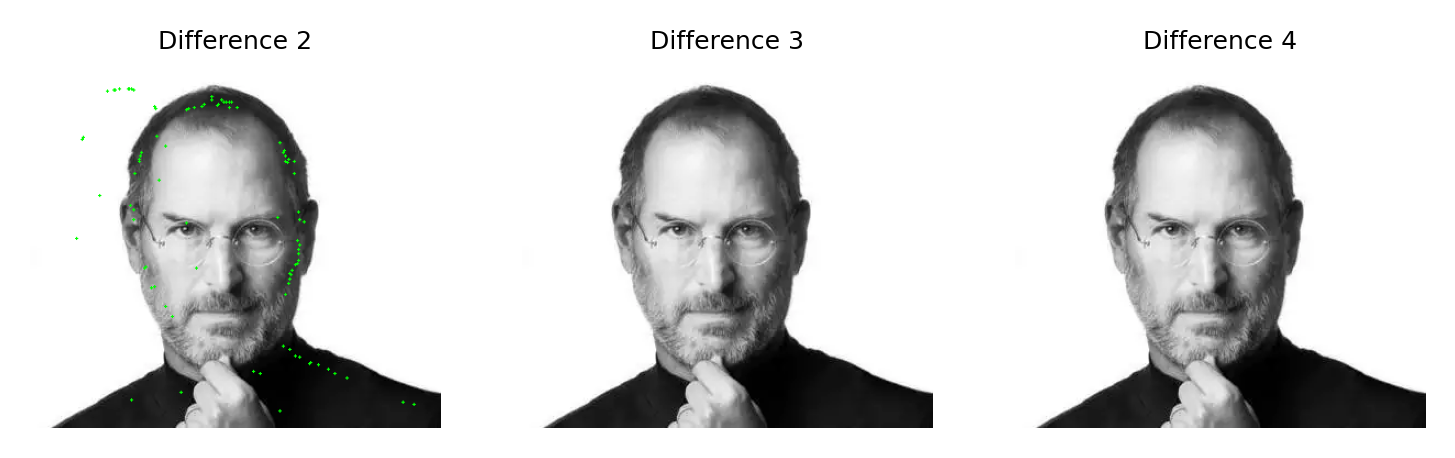

In [33]:
lr = 1  # 第lr层

extrame_points = ExtremePointDetection(difference_images = DoG_space[lr])
DoG_space_copy = DoG_space[lr].copy()

# 读取图像
image_ = cv2.imread("images/qbs.jpg")
# image_ = cv2.resize(image_, dsize=(DoG_space_copy[0].shape[1], DoG_space_copy[0].shape[0]))

image_space = []
for img in DoG_space_copy:
    # image_space.append(cv2.cvtColor(image_, cv2.COLOR_GRAY2RGB))
    image_space.append(image_.copy())

# 可视化Octave2的极值点：
for layer, row, col in extrame_points:
    cv2.circle(image_space[layer], center=(col, row), radius=1, color=[0,255,0], thickness=-1)

plt.figure(dpi=300)
for i in range(1,4):
    plt.subplot(1,3,i)
    plt.imshow(convert(image_space[i]))
    plt.title("Difference {}".format(i+1), fontsize=6)
    plt.axis('off')
plt.show()

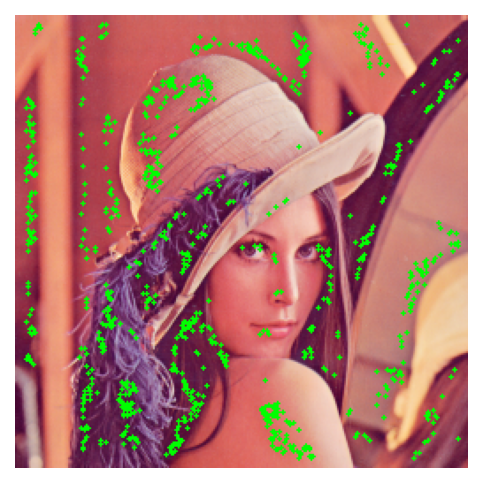

In [64]:
imshow(image_space[1])

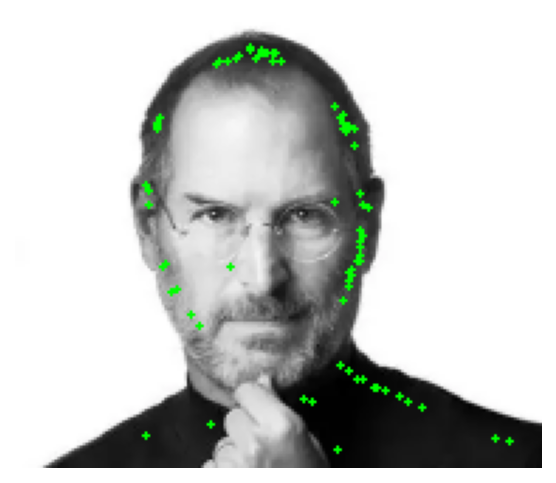

In [46]:
imshow(image_space[1])

In [68]:
len(extrame_points)

2760

In [17]:
max(x)

3

In [19]:
len(np.where(x==x.max()))

(array([4, 5]),)

In [25]:
np.array(DoG_space[0]).shape

(5, 856, 1144)

In [26]:
np.array(DoG_space[1]).shape

(5, 428, 572)